In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
import scipy.signal as signal
from math import log10

**SE OBTIENE EL DATASET**




In [2]:
array1 = np.genfromtxt("ECG_ejercicio.txt", delimiter="\t")
array1 = array1[:,-2]
promedio = np.mean(array1)
array1=array1-promedio
resolution=10
Fs = 1000 #Frecuencia de muestreo del dispositivo de adquisición
Ts=1/Fs
n = np.arange(0,array1.shape[0])  # t = n*Ts
t = n*Ts

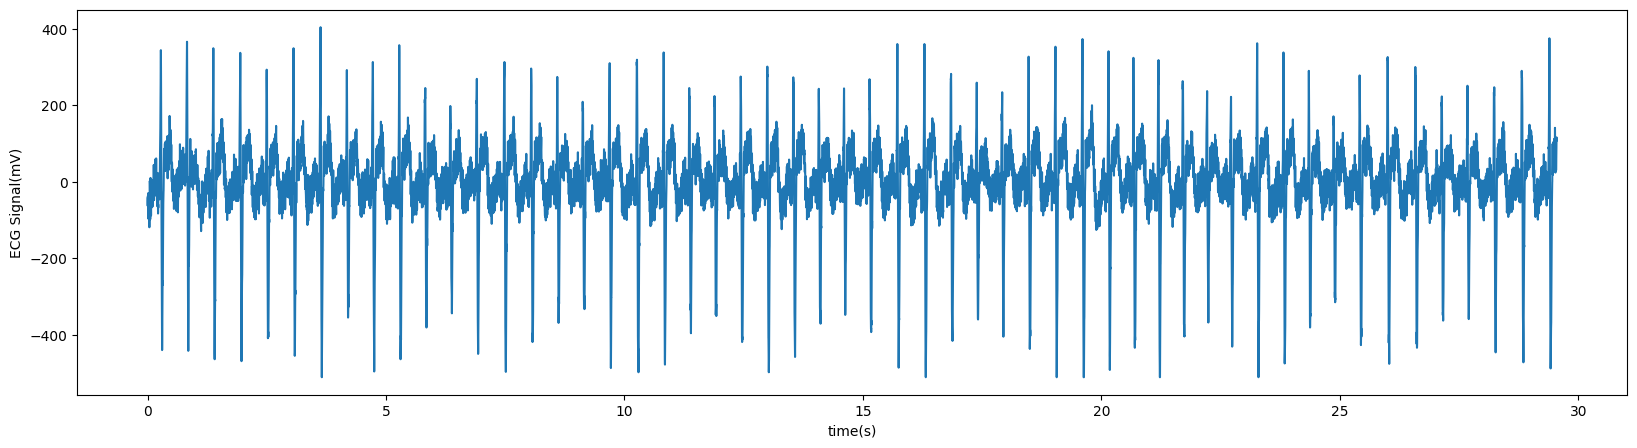

In [3]:
# A numpy
mtime = t
voltaje = array1*1 #Factor de escalamiento 1 mv
plt.figure(figsize=(20,5))
plt.plot(mtime, voltaje)
plt.ylabel('ECG Signal(mV)')
plt.xlabel('time(s)')
plt.show()

**SE ANALIZA LA SEÑAL EN FRECUENCIA**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

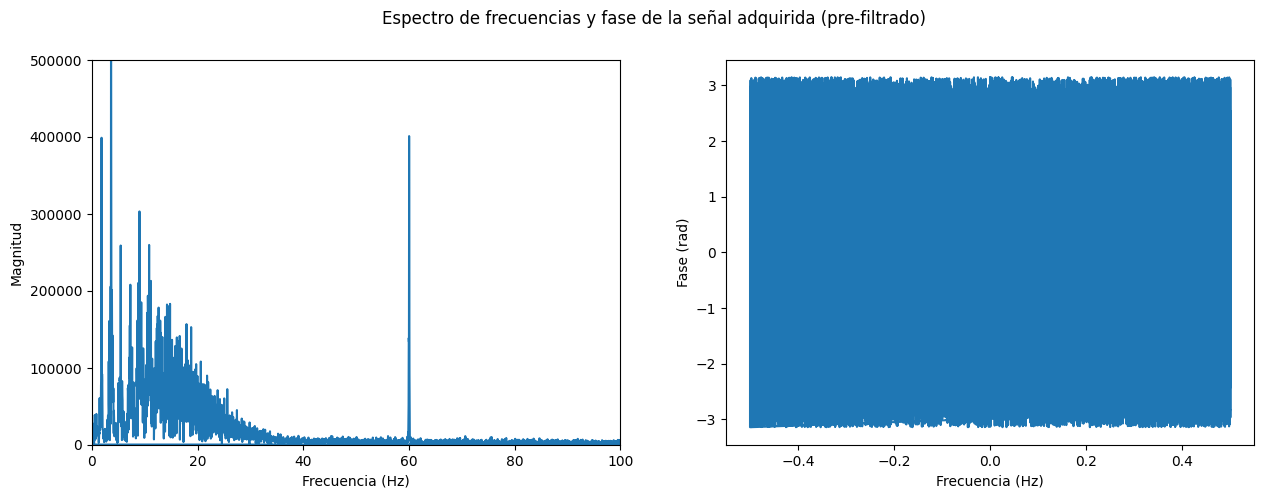

In [4]:
# Analizar el Fourier
ecg_signal = voltaje

# Transformada de Fourier
fft_signal = np.fft.fft(ecg_signal)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)

# Fase de la transformada de Fourier
phase_signal = np.angle(fft_signal)

# Frecuencias
freqs = np.fft.fftfreq(len(ecg_signal))

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(freqs*1000, mag_signal)
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Magnitud')
axs[0].set_ylim([0, 500000])
axs[0].set_xlim([0, 100])


axs[1].plot(freqs, phase_signal)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Fase (rad)')

fig.suptitle("Espectro de frecuencias y fase de la señal adquirida (pre-filtrado)")

plt.savefig("espectro_before_filtering.png")

plt.show()


En el gráfico anterior, existe un ruido en 50 Hz y armónicos en 150 HZ. Por lo tanto, se debe filtrar.

Se propone utilizar filtros digitales Notch



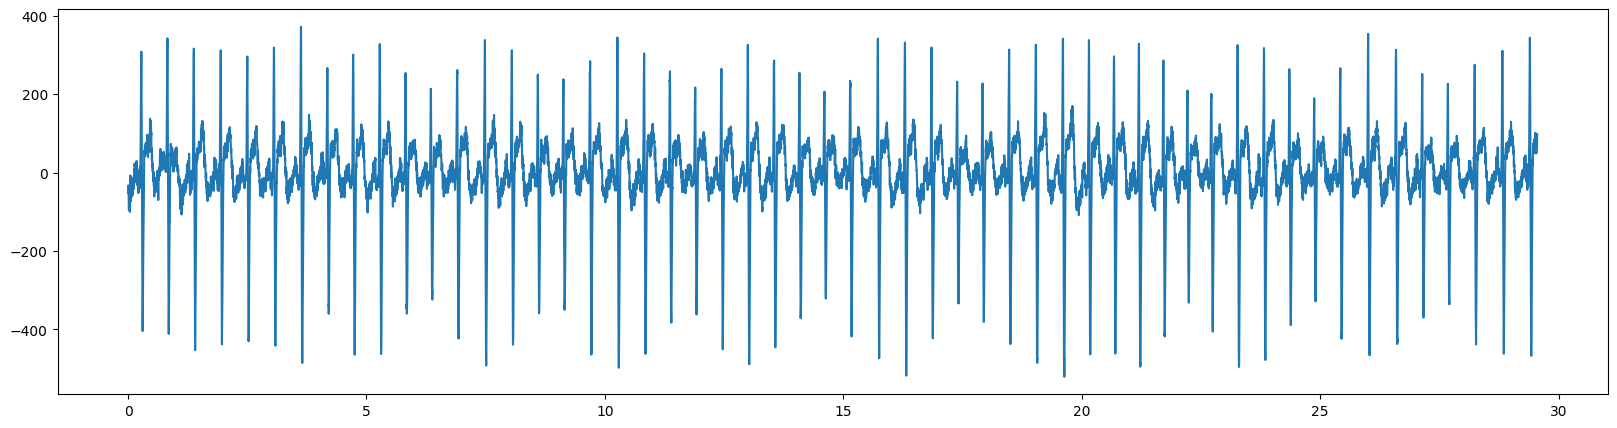

In [5]:
# Utilizar filtros Notch para quitar frecuencias que hagan ruido
from scipy.signal import iirnotch, lfilter
fs = 1/Ts  # Frecuencia de muestreo (Hz)
f0 = 60.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b, a, ecg_signal)
y = lfilter(b, a, y)
fs = 1/Ts  # Frecuencia de muestreo (Hz)
f0 = 150.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)
plt.figure(figsize=(20,5))
#plt.xlim(0,200)
plt.plot(mtime,y)
plt.show()

Regresamos a verificar las atenuaciones de los filtros en frecuencia

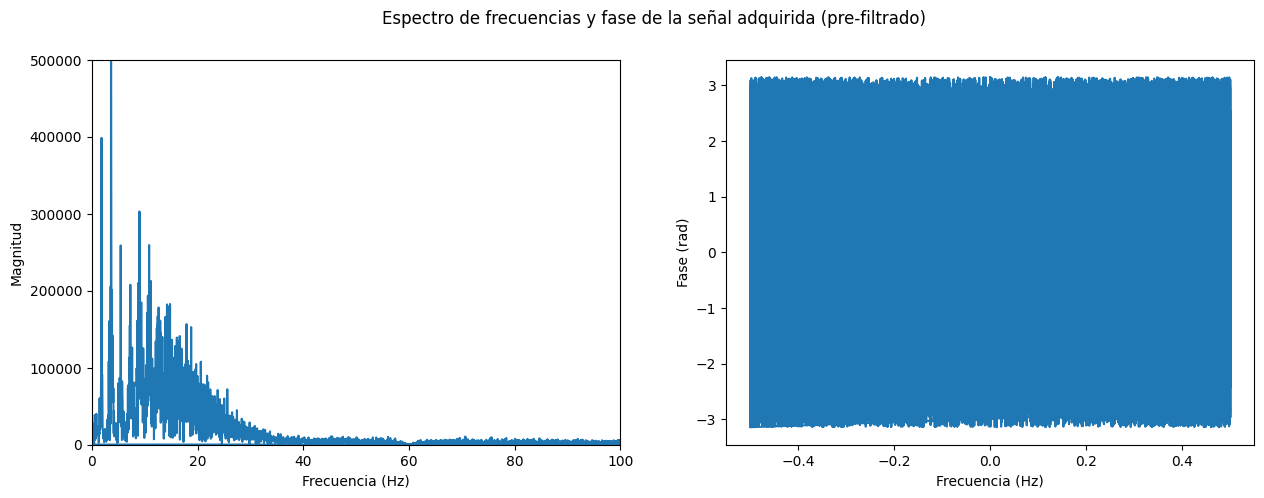

In [6]:
# Transformada de Fourier
fft_signal = np.fft.fft(y)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)

# Fase de la transformada de Fourier
phase_signal = np.angle(fft_signal)

# Frecuencias
freqs = np.fft.fftfreq(len(y))

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(freqs*1000, mag_signal)
axs[0].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Magnitud')
axs[0].set_ylim([0, 500000])
axs[0].set_xlim([0, 100])


axs[1].plot(freqs, phase_signal)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel('Fase (rad)')

fig.suptitle("Espectro de frecuencias y fase de la señal adquirida (pre-filtrado)")

plt.savefig("espectro_before_filtering.png")

plt.show()

**FILTRADO DE PASA BANDA**

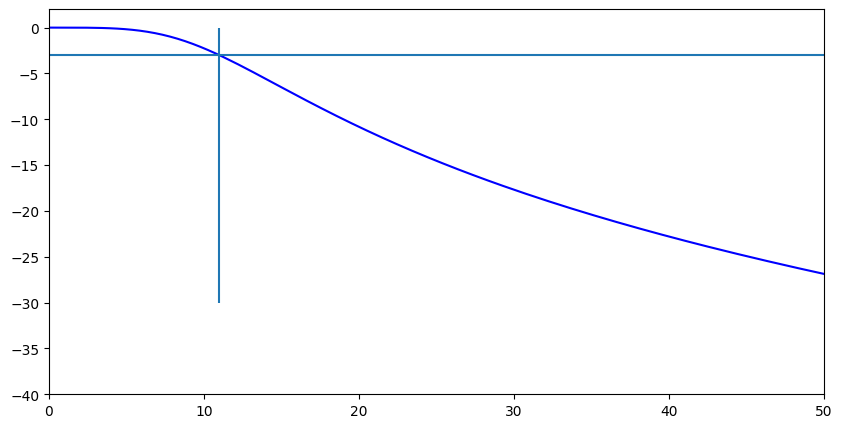

In [7]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

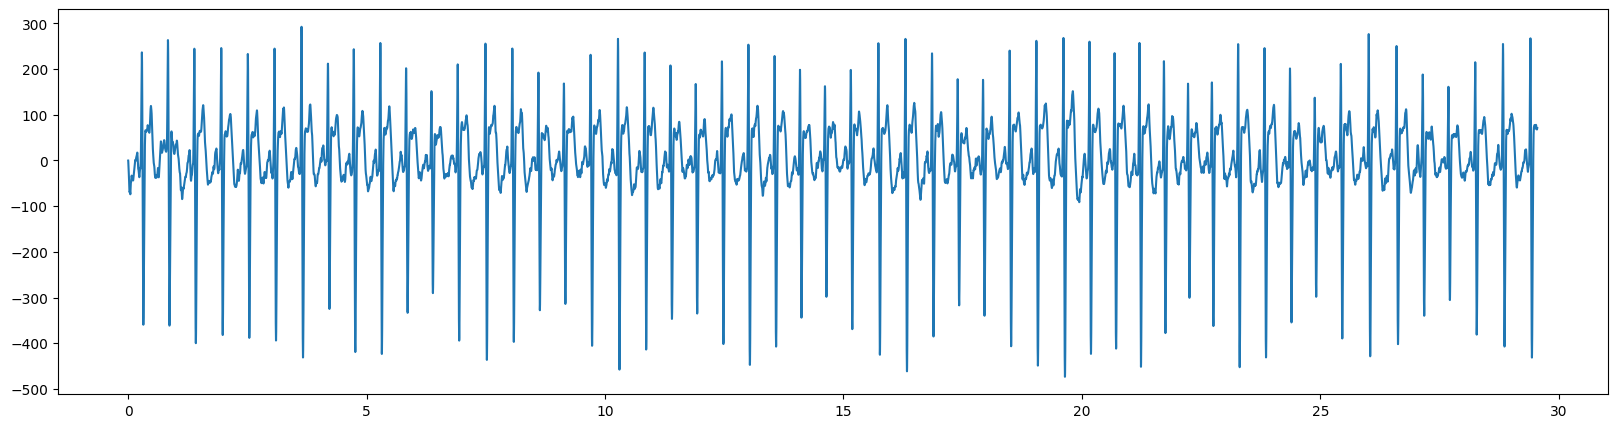

In [8]:
fpb_signal = lfilter(b, a, y)
plt.figure(figsize=(20,5))
plt.plot(mtime,fpb_signal)
plt.show()

**FILTRO PASA ALTO**

C:\Users\dairc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


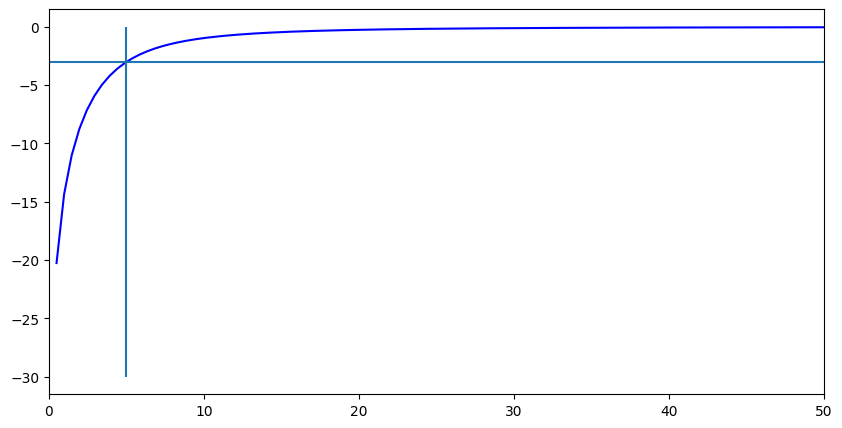

In [9]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()


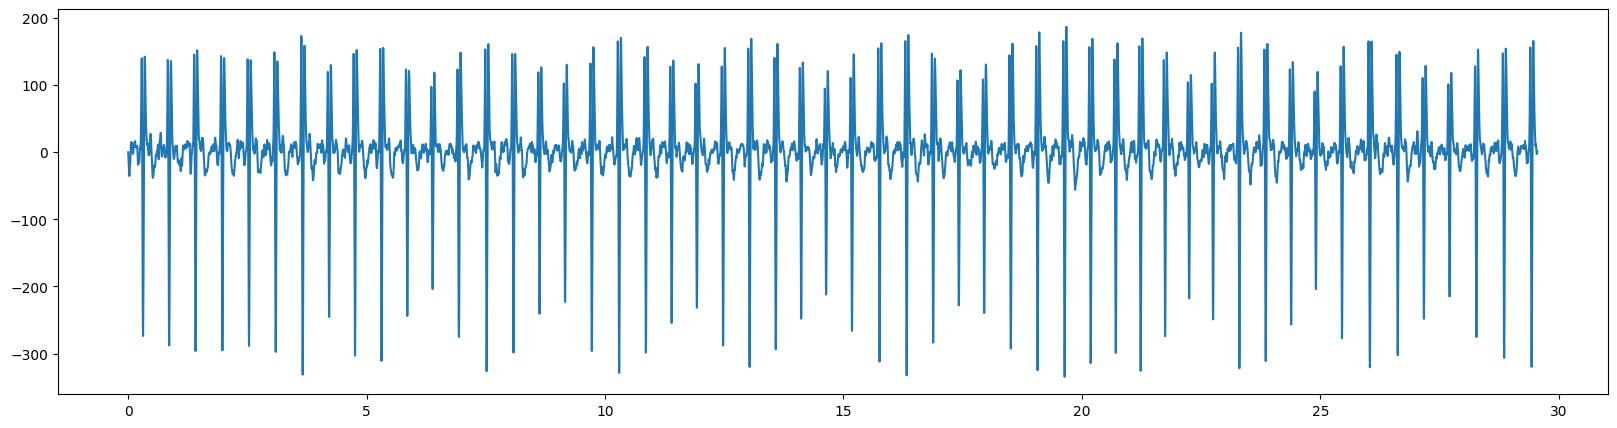

In [10]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fpa_signal)
plt.show()

**OPERADOR DERIVATIVO**

En el artículo nos dan la siguiente función que describe al operador:

y[n]=(1/8)(−x[n−2]−2x[n−1]+2x[n+1]+x[n+2])

Para que esta ecuación pueda ser utilizada necesitamos encuadrarla en un rango de  [0,+∞]  haciendo que  n=+2  entonces tenemos:

y[n]=(1/8)(−x[n]−2x[n+1]+2x[n+3]+x[n+4]) 

Por lo tanto:

b=[−1,−2,0,2,1]

C:\Users\dairc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


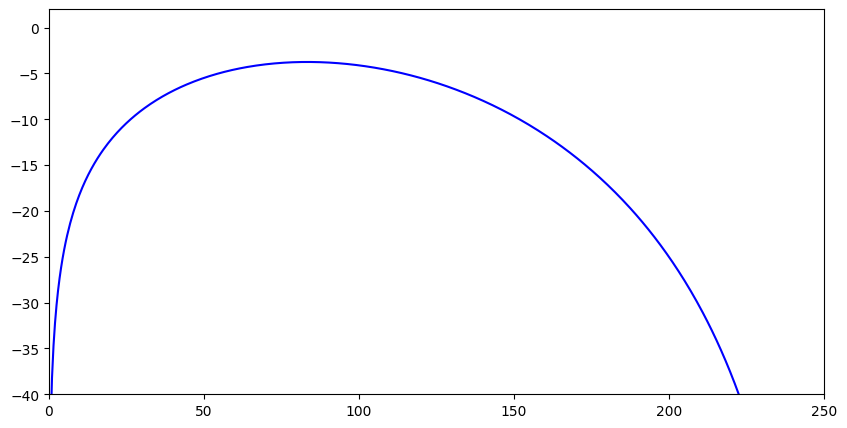

In [11]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

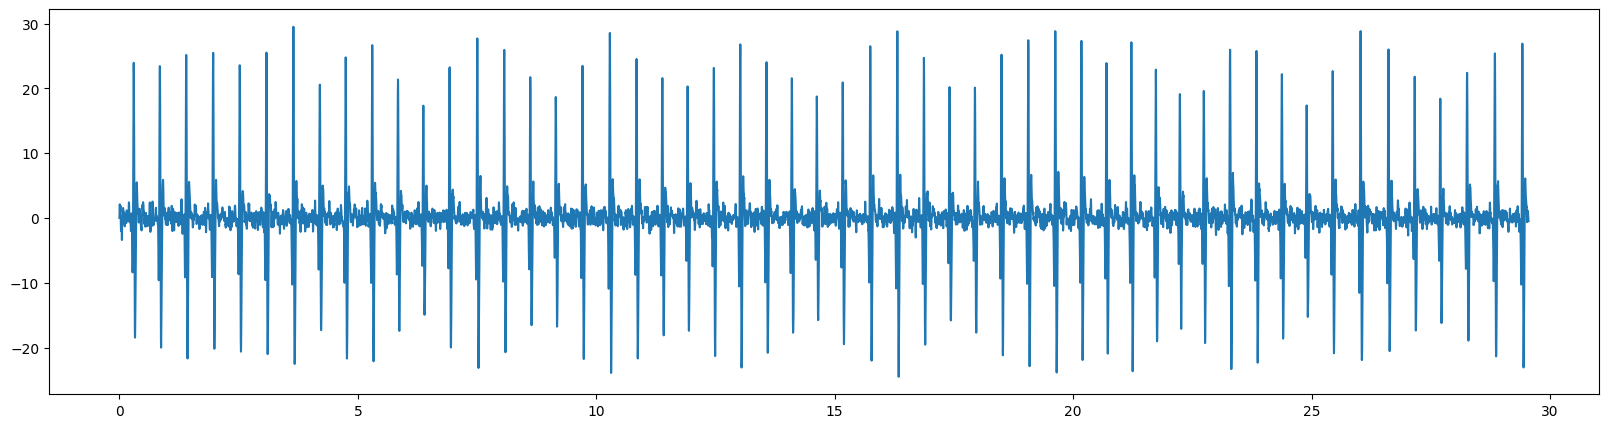

In [12]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fd_signal)
plt.show()

**OPERADOR CUADRÁTICO**

Este operador solo tiene como función elevar al cuadrado los valores de la señal.

y[n]=x^2[n]

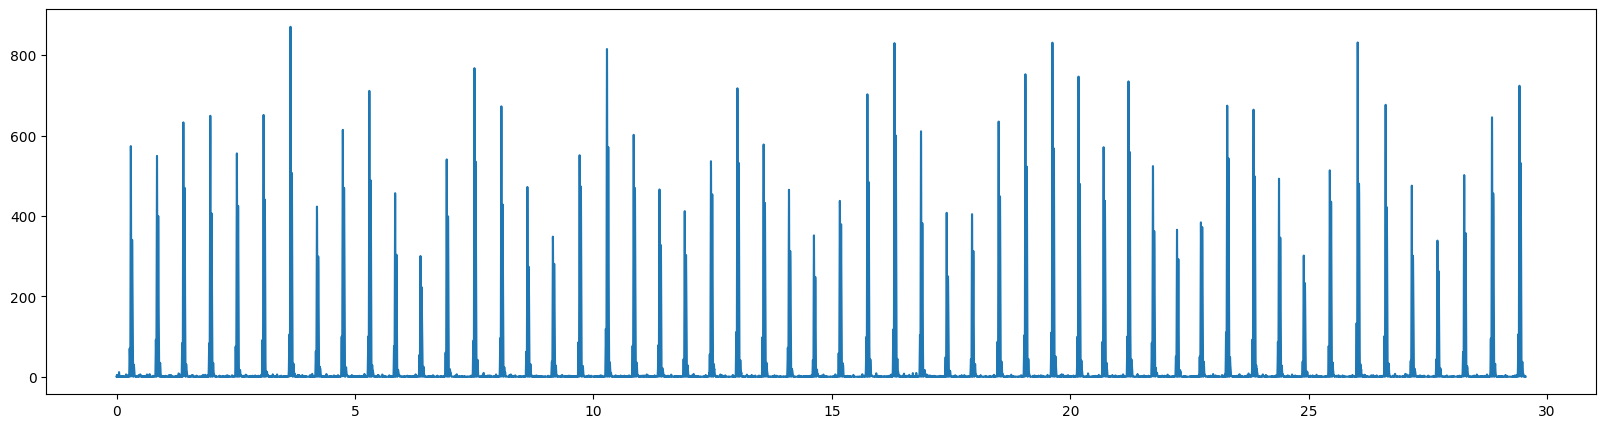

In [13]:
# Filtro cuadrado
f_sq = np.square(fd_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime, f_sq)
#plt.xlim(50,200)
plt.show()

**OPERADOR MOVING WINDOW INTEGRATION**

Este operador tiene como función extraer ciertas características de la onda.

y[n]=(1/N)(x[n−(N−1)]+x[n−(N−2)]+..+x[n])

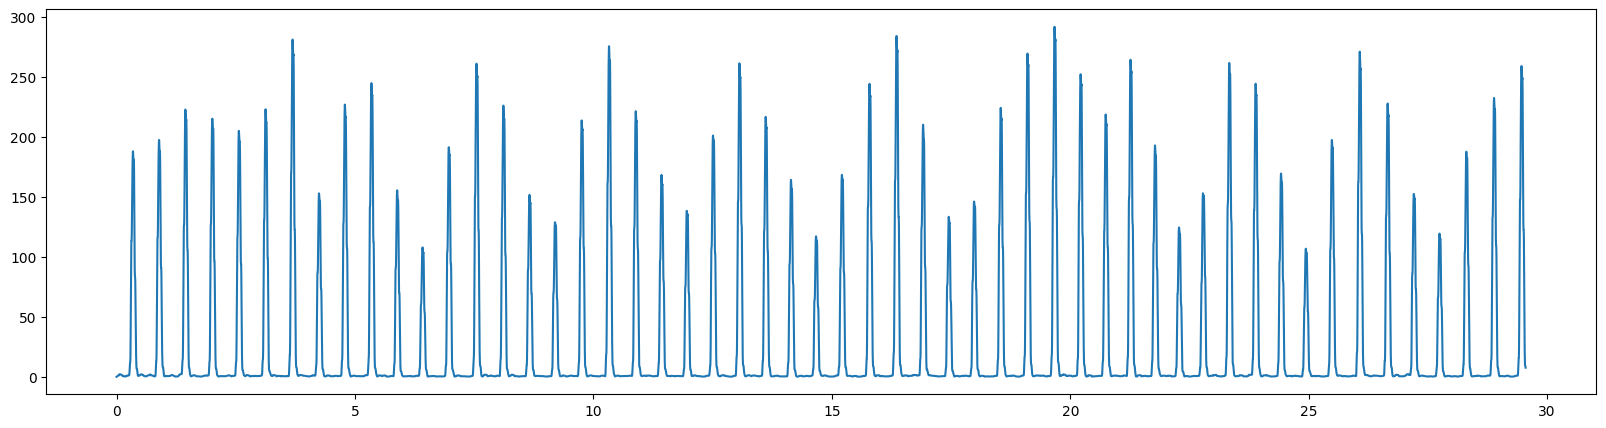

In [14]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(mtime,fi_signal)
plt.show()

Colocando marcadores en los picos

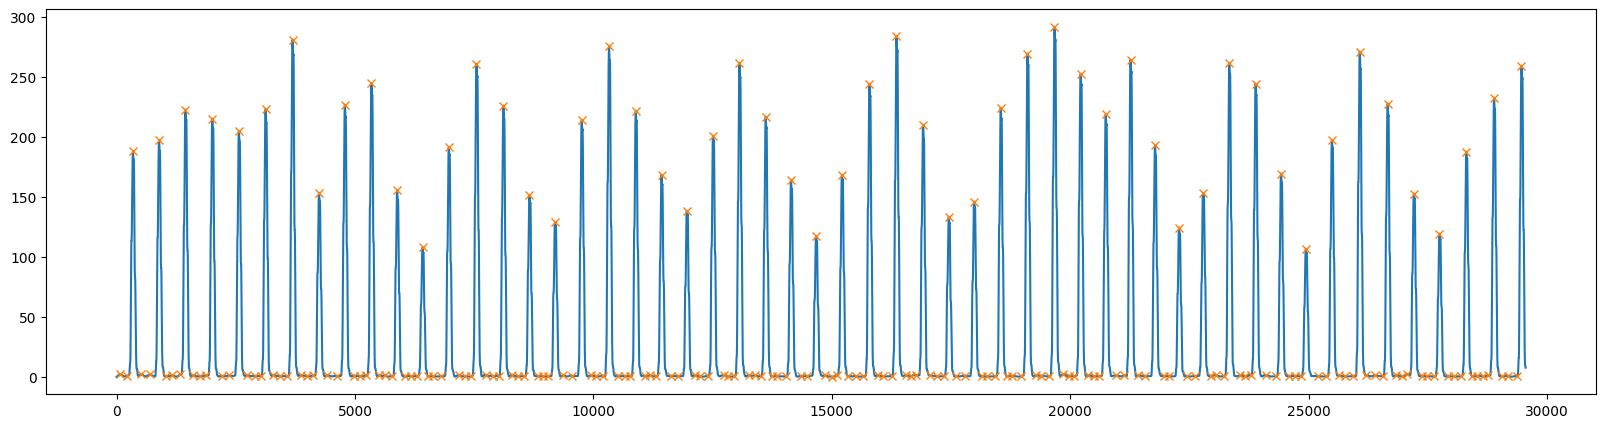

In [15]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=100)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

**ANÁLISIS DE THRESHOLD**

El valor del umbral de pico R de entrada es  72.95062898074109
El valor del umbral de ruido de entrada es  27.347344305677854


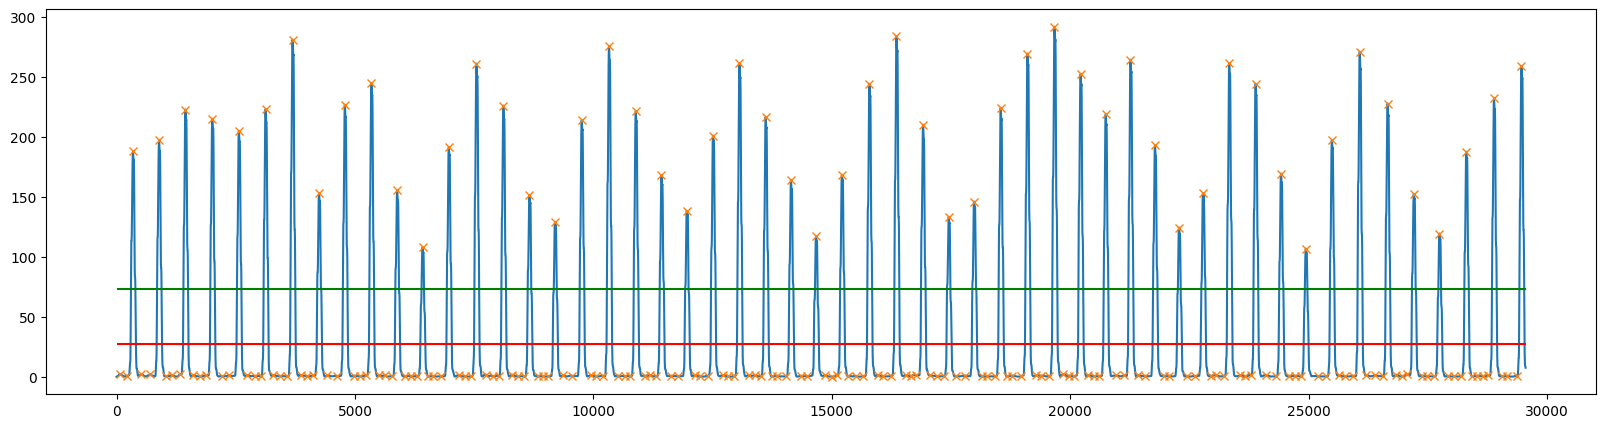

In [16]:
# Training Part to set Threshold I1 and Threshold I2
# Para las primeras muestras en 2 segundos
# Para efectos del ejercicio vamos a analizar toda la señal
f_samples = len(peaks)
th_I1 = np.max(fi_signal[peaks[:f_samples]])*0.25
th_I2 = 0.5*np.mean(fi_signal[peaks[:f_samples]])
print ("El valor del umbral de pico R de entrada es ", th_I1)
print ("El valor del umbral de ruido de entrada es ", th_I2)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
#plt.xlim(50,1000)
plt.plot(peaks, fi_signal[peaks], "x")
plt.hlines(th_I1, 0, len(fi_signal), colors='green')
plt.hlines(th_I2, 0, len(fi_signal), colors='red')
plt.show()

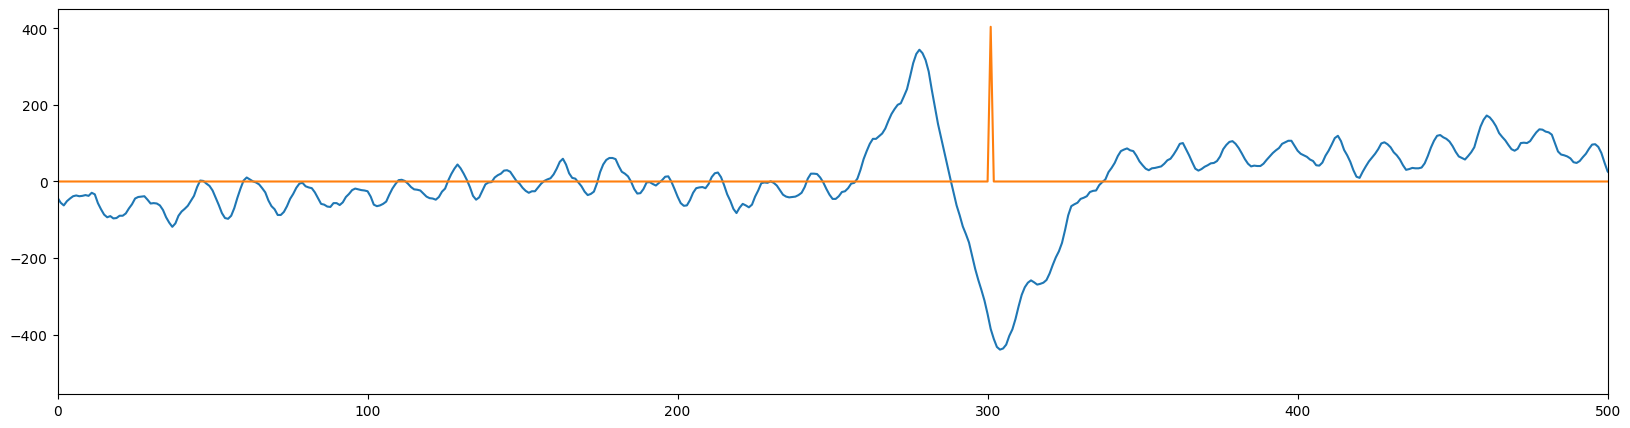

In [17]:
end_qrs = fi_signal > th_I1
roll_qrs_r = np.roll(end_qrs, 1)
roll_qrs_l = np.roll(end_qrs, -1)
end_qrs = np.logical_xor(end_qrs ,roll_qrs_r)
end_qrs = np.logical_and(end_qrs ,roll_qrs_l)
plt.figure(figsize=(20,5))
plt.xlim(0,500)
plt.plot(ecg_signal)
plt.plot(end_qrs*np.max(ecg_signal))
plt.show()

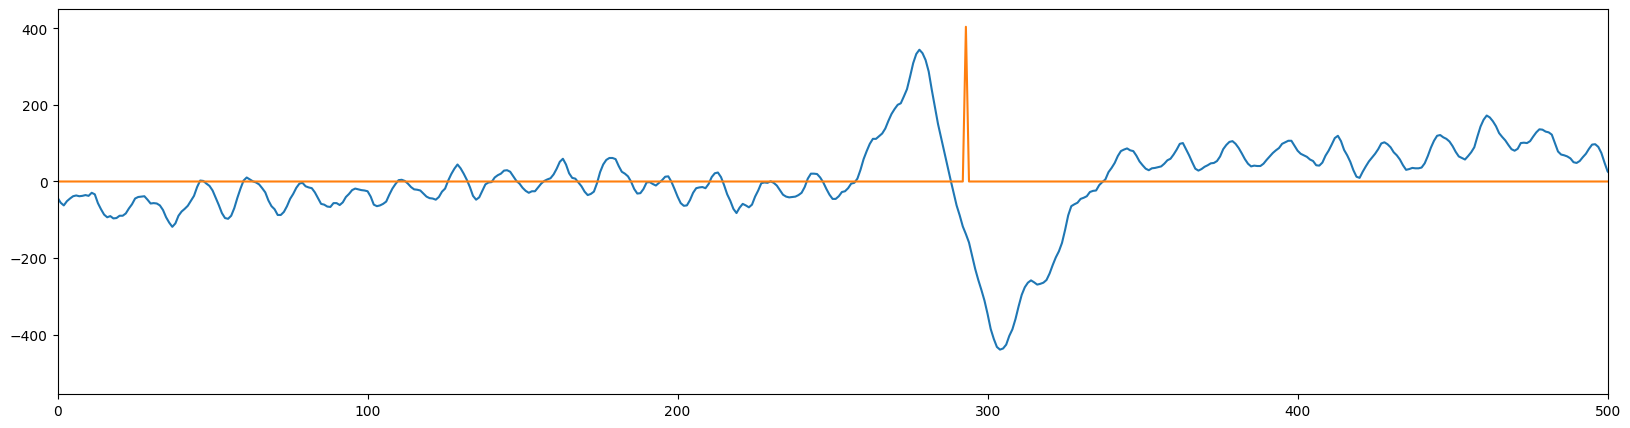

In [18]:
start_qrs = fi_signal < th_I2
roll_qrs_l = np.roll(start_qrs, -1)
roll_qrs_r = np.roll(start_qrs, 1)
start_qrs = np.logical_xor(start_qrs ,roll_qrs_l)
start_qrs = np.logical_and(start_qrs ,roll_qrs_r)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.xlim(0,500)
plt.plot(start_qrs*np.max(ecg_signal))
plt.show()

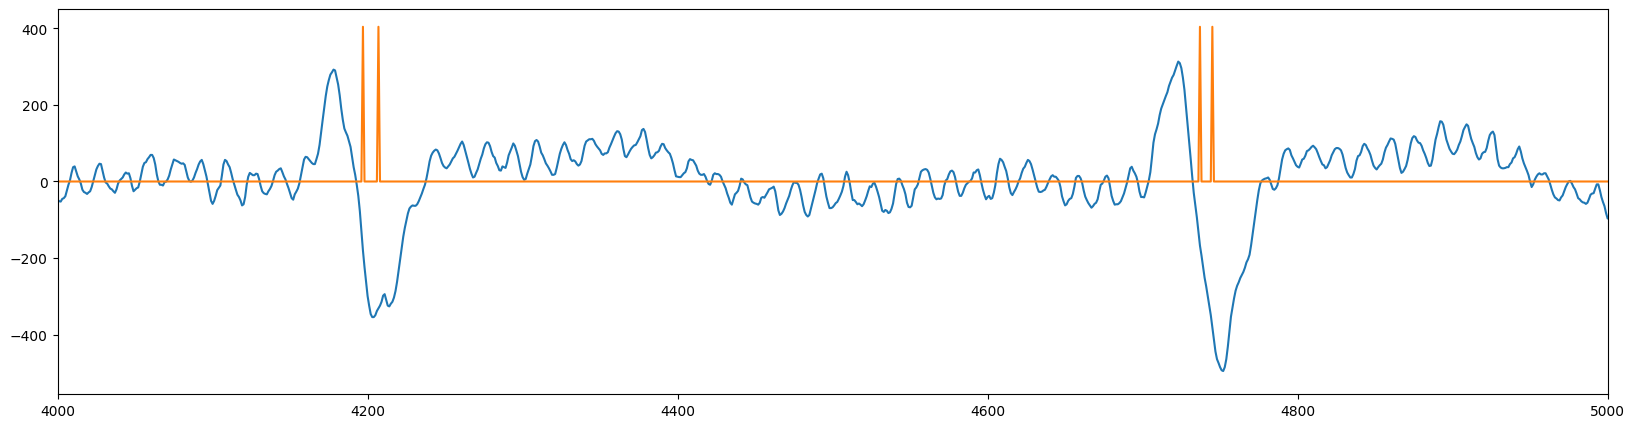

In [19]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.xlim(4000,5000)
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()


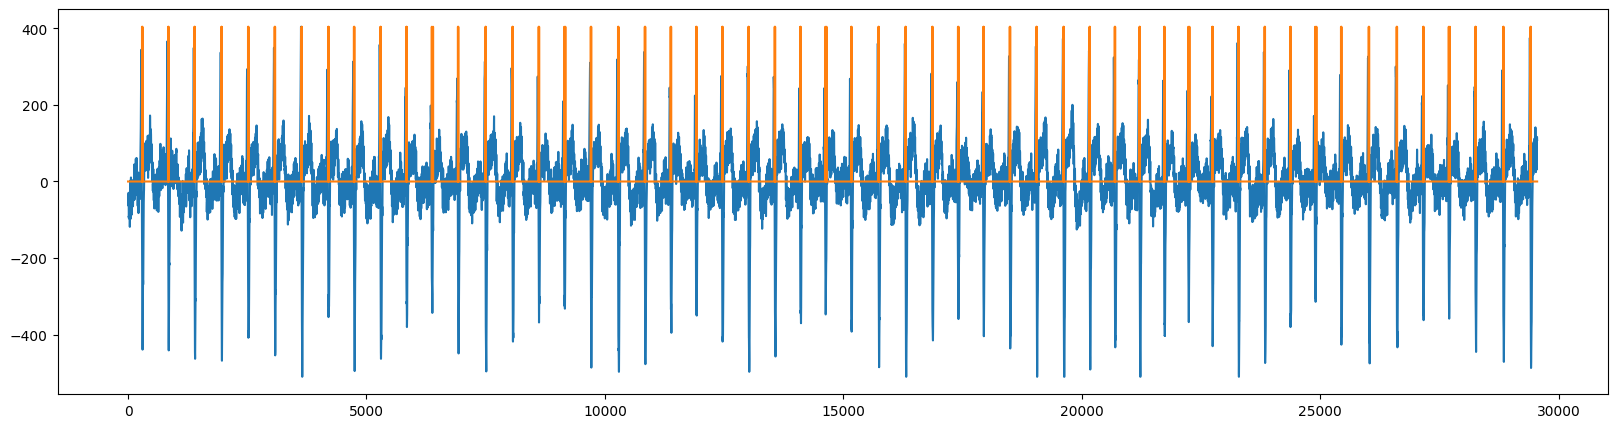

In [20]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()